# 시계열 데이터(Time Series Data) 다루기

## II. 전염병 예측_V1 [ 간단한 DataSet]

- 문제 정의
    - 3일 동안의 확진자 수 추이를 보고 다음날 확진자 수를 예측

In [1]:
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, GRU, LSTM, Bidirectional, Conv1D, MaxPooling1D, Flatten
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

2023-05-14 15:39:38.540267: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


<details>
  <summary>Library</summary>



- from keras.models import Sequential
  - 케라스의 모델 도구(models)중 시퀀셜 모델을 불러오는 명령어
- from keras.layers import SimpleRNN, Dense, GRU, LSTM, Bidirectional, Conv1D, MaxPooling1D
  - 레이어 도구(layers)중 SimpleRNN과 Dense도구등을 불러오는 명령어
- from sklearn.prerprocessing import MinMaxSacler
  - 데이터를 정규화하기 위한 MinMaaxScaler 함수를 불러오는 명령어
- from sklearn.metrics import mean_squared_error
  - 결과의 정확도를 계산하기 위한 함수인 mean_squared_error를 불러오는 명령어
- from sklearn.model_selection import train_test_split
  - 데이터를 훈련데이터와 검증 데이터로 나누는 명령어
- import math
  - 수학 계산을 도와주는 math 라이브러리
- import numpy as np
  - 수학 계산 라이브러리 numpy를 불러오고 np로 줄여서 사용
- import matplotlib.pyplot as plt
  - 그래프 라이브러리중 pyplot 라이브러리 사용
  - plt로 줄여서 사용

</details>

### 1. 데이터 불러오기

In [2]:
import os
print(os.getcwd())
os.chdir("/Users/ryu/Desktop/Desktop ryuseungho's MacBook Air/Data Scientist/Study_Organization/DeepLearning/RNN(LSTM,GRU)/Data")
print(os.getcwd())

/Users/ryu/Desktop/Desktop ryuseungho's MacBook Air/Data Scientist/Study_Organization/DeepLearning/RNN(LSTM,GRU)
/Users/ryu/Desktop/Desktop ryuseungho's MacBook Air/Data Scientist/Study_Organization/DeepLearning/RNN(LSTM,GRU)/Data


In [3]:
# github 저장소에서 데이터 불러오기
# !git clone https://github.com/yhlee1627/deeplearning.git
# git이 안될경우 주소에서 다운로드

df = pd.read_csv('./deeplearning/corona_daily.csv', usecols = [3], engine = 'python', skipfooter = 3)
print(df)
dataset = df.values
dataset = df.astype('float32')

     Confirmed
0           24
1           24
2           27
3           27
4           28
..         ...
107      11190
108      11206
109      11225
110      11265
111      11344

[112 rows x 1 columns]


### 2. 데이터 전처리

#### 2-1. 정규화

In [4]:
# 데이터를 정규화 하는 범위를 0 ~ 1
scaler = MinMaxScaler(feature_range = (0,1))
# 데이터 정규화 적용
Dataset = scaler.fit_transform(dataset)

#### 2-2. 데이터 분할

In [5]:
# 전체 데이터를 Training Data(80%), Test Data(20%) 분할
train_data, test_data = train_test_split(Dataset, test_size = 0.2, shuffle = False)
print(f"Train Data 개수 : {len(train_data)}, Test Data 개수 : {len(test_data)}")

Train Data 개수89, Test Data 개수 : 23


- 데이터 형태 변경하기
    - 3일치의 데이터를 사용하여 4번째 날짜 값을 예측
    <img src='https://p.ipic.vip/rrjtb8.png' width=50%>

In [6]:
# dataset : 원 데이터, look_back : 연속되는 데이터 개수
def create_dataset(dataset, look_back):
    x_data = []
    y_data = []
    for i in range(len(dataset) - look_back - 1):
        data = dataset[i:(i+look_back), 0]
        x_data.append(data)
        y_data.append(dataset[i + look_back, 0])
    return np.array(x_data), np.array(y_data)

- 3일치의 데이터를 사용하므로 look_back = 3

In [7]:
look_back = 3
x_train, y_train = create_dataset(train_data, look_back)
x_test, y_test = create_dataset(test_data, look_back)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(85, 3) (85,)
(19, 3) (19,)


- 2차원 배열을 3차원 배열로
<img src='https://p.ipic.vip/z9ia14.png' width = 50%>

In [8]:
X_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
X_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
print(X_train.shape)
print(X_test.shape)

(85, 3, 1)
(19, 3, 1)


### 3. 모델 정의

#### 3-1. 순환 신경망(RNN; Recurrent Neural Network)
- 순차적인 데이터(Sequence Data)를 처리하기 위한 인공 신경망
    - 어떤 특정 부분이 반복되는 구조에서 순서를 학습하기에 효과적
    - 시계열 데이터, 자연어 등에 적용 가능
    - 기존 Neural Network와 달리 '기억(Hidden State)'를 가지고 있음
    - 은닉 계층 안에 하나 이상의 순환 계층을 갖는 신경망 구조
        - 이전 단계의 출력 값이 현재 단계의 입력 값으로 다시 들어가는 반복 구조
        - 가중치가 모든 타임 스텝에서 공유됨

<details>
<summary>RNN Process</summary>

<img src='https://p.ipic.vip/kk81uo.png'>

</details>

In [9]:
model = Sequential()
model.add(SimpleRNN(3, input_shape = (look_back, 1)))
model.add(Dense(1, activation = 'linear'))       # 최종 예측 값은 연속된 데이터 이후의 값, 즉 확진자의 수
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 3)                 15        
                                                                 
 dense (Dense)               (None, 1)                 4         
                                                                 
Total params: 19
Trainable params: 19
Non-trainable params: 0
_________________________________________________________________


2023-05-14 15:39:43.430831: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### 3-2. LSTM ; Long Short Term Memory

- RNN의 **장기의존성 문제**와 **기울기 소실 문제**를 해결한 알고리즘
    - 가중치 행렬$W$의 행렬 곱 연산이 그레이디언트 경로에 나타나지 않도록 구조 변경
- 기존 RNN에 장기 기억 셀(Cell State)을 추가함
    - $c_t$를 연결하는 경로에는 가중치 행렬 $W$의 행렬 곱 연산이 없음
    <img src='https://p.ipic.vip/devzvc.png' width=80%>
- 장기 기억 셀 연산에 사용되는 게이트 추가
    - Fprget Gate($f_t$) : 과거의 정보를 얼마나 유지할 것인가?
    - Input Gate($i_t$) : 새로 입력된 정보를 얼만큼 활용할 것인가?
    - Output Gate($o_t$) : Cell State에서 나온 정보를 얼마나 출력할 것인가? 

<details>
<summary>LSTM Process</summary>

![RNN(LSTM,GRU)_4](https://p.ipic.vip/73bjz5.png)

</details>

In [10]:
model = Sequential()
model.add(LSTM(3, input_shape = (look_back, 1)))
model.add(Dense(1, activation = 'linear'))       # 최종 예측 값은 연속된 데이터 이후의 값, 즉 확진자의 수
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 3)                 60        
                                                                 
 dense_1 (Dense)             (None, 1)                 4         
                                                                 
Total params: 64
Trainable params: 64
Non-trainable params: 0
_________________________________________________________________


#### 3-3. GRU ; Gated Recureent Unit

LSTM의 장점을 유지하면서 게이트 구조를 단순하게 만든 순환 신경망

- 업데이트 게이트(Update Gate) = Forget Gate + Input Gate
  - 과거의 기억중 사용할 정보의 양과 현 시점의 입력 정보 중 사용할 정보 수집
- 리셋 게이트(Reset Gate)
  - 현 시점의 입력 정보 중 새로운 정보를 추가할 때, 과거의 기억 중 필요한 정보의 양 계산
- 장기 기억 셀(Cell State)을 삭제
  - 은닉 상태($h_{t-1}$)가 장기 기억과 단기 기억 모두를 기억하도록 함
- 출력 게이트가 존재하지 않음
  - 전체 상태 벡터가 매 타임 스텝마다 출력
  


<details>
<summary>GRU Process</summary>

<img src='https://p.ipic.vip/6obmtd.png'>

</details>

In [11]:
model = Sequential()
model.add(GRU(3, input_shape = (look_back, 1)))
model.add(Dense(1, activation = 'linear'))       # 최종 예측 값은 연속된 데이터 이후의 값, 즉 확진자의 수
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 3)                 54        
                                                                 
 dense_2 (Dense)             (None, 1)                 4         
                                                                 
Total params: 58
Trainable params: 58
Non-trainable params: 0
_________________________________________________________________


#### 3-4. 양방향(Bidirrectional) LSTM/GRU

- 양방향 순환 층(Bidirectional Recurrent Layer)
  - 순환 네트워크에 같은 정보를 다른 방향으로 주입하여 정확도를 높이고 기억을 좀 더 오래 유지
  - 이전의 층이 전체 출력 시퀀스를 반환해야 함 [ return_sequence = True ]

<details>
<summary>양방향 LSTM/GRU</summary>



<img src='https://p.ipic.vip/2hj9xp.png'>

</details>

In [12]:
model = Sequential()
model.add(Bidirectional(LSTM(3), input_shape = (look_back, 1))) # SimpleRNN, LSTM, GRU
model.add(Dense(1, activation = 'linear'))       # 최종 예측 값은 연속된 데이터 이후의 값, 즉 확진자의 수
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 6)                120       
 l)                                                              
                                                                 
 dense_3 (Dense)             (None, 1)                 7         
                                                                 
Total params: 127
Trainable params: 127
Non-trainable params: 0
_________________________________________________________________


#### 3-5. 1D CNN + LSTM/GRU

<details>
<summary>1D CNN + LSTM/GRU</summary>
<img src='https://p.ipic.vip/bzx124.png'>

</details>

In [18]:
model = Sequential()
model.add(Conv1D(filters=32,
                 kernel_size=1,
                 strides=1,
                 padding='valid',
                 input_shape=(look_back, 1), 
                 use_bias=False, name='c1d'))
model.add(MaxPooling1D(pool_size = 3))
model.add(LSTM(32))
model.add(Dense(1, activation = 'linear'))
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 c1d (Conv1D)                (None, 3, 32)             32        
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 1, 32)            0         
 1D)                                                             
                                                                 
 lstm_3 (LSTM)               (None, 32)                8320      
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 8,385
Trainable params: 8,385
Non-trainable params: 0
_________________________________________________________________


### 4. 모델 학습

In [19]:
model.compile(loss = 'mse', optimizer = 'adam')
model.fit(X_train, y_train, epochs = 100, batch_size = 1, verbose = 1)

Epoch 1/100
85/85 [==============================] - 1s 1ms/step - loss: 0.1677
Epoch 2/100
85/85 [==============================] - 0s 1ms/step - loss: 0.0026
Epoch 3/100
85/85 [==============================] - 0s 1ms/step - loss: 0.0020
Epoch 4/100
85/85 [==============================] - 0s 985us/step - loss: 0.0017
Epoch 5/100
85/85 [==============================] - 0s 1ms/step - loss: 0.0014
Epoch 6/100
85/85 [==============================] - 0s 970us/step - loss: 0.0012
Epoch 7/100
85/85 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 8/100
85/85 [==============================] - 0s 975us/step - loss: 0.0010
Epoch 9/100
85/85 [==============================] - 0s 1ms/step - loss: 8.9466e-04
Epoch 10/100
85/85 [==============================] - 0s 1ms/step - loss: 8.2010e-04
Epoch 11/100
85/85 [==============================] - 0s 1ms/step - loss: 6.8609e-04
Epoch 12/100
85/85 [==============================] - 0s 977us/step - loss: 6.0163e-04
Epoch 13/100


### 5. 데이터 예측

In [20]:
# 모델을 적용한 출력값 (0~1)
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)

# scaler를 통하여 실제 값으로 변환
TrainPredict = scaler.inverse_transform(trainPredict)  # 훈련 데이터의 예측값
Y_train = scaler.inverse_transform([y_train])          # 훈련 데이터의 타깃값
TestPredict = scaler.inverse_transform(testPredict)    # 테스트 데이터의 예측값
Y_test = scaler.inverse_transform([y_test])            # 테스트 데이터의 타깃값

1/1 [==============================] - 0s 14ms/step


### 6. 모델의 정확도

In [21]:
trainScore = math.sqrt(mean_squared_error(Y_train[0], TrainPredict[:,0]))
print(f'Train Score: {trainScore:.2f} RMSE')

testScore = math.sqrt(mean_squared_error(Y_test[0], TestPredict[:,0]))
print(f'Test Score: {testScore:.2f} RMSE')

Train Score: 66.11 RMSE
Test Score: 68.58 RMSE


### 7. 시각화(실제 값과 예측값 그래프)

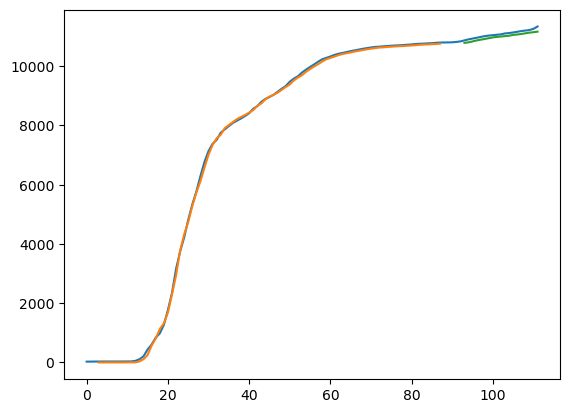

In [22]:
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(TrainPredict)+look_back, :] = TrainPredict
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(TrainPredict)+(look_back+1)*2:len(dataset), :] = TestPredict

plt.plot(dataset)               # 파란색 : 실제 값
plt.plot(trainPredictPlot)      # 주황색 : Training Data 예측값
plt.plot(testPredictPlot)       # 초록색 : Test Data 예측값
plt.show()